In [1]:

import numpy as np
import openhd as hd
import matplotlib.pyplot as plt

/home/hpc/iwi3/iwi3083h/.local/lib/python3.8/site-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


In [2]:
import torch
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.transforms import Grayscale
from torchvision.transforms import ColorJitter
train_data = datasets.CIFAR10(
    root = 'data',
    train = True,                         
    transform = transforms.Compose([ToTensor()]), 
    download = False,            
)
test_data = datasets.CIFAR10(
    root = 'data', 
    train = False, 
    transform = transforms.Compose([ToTensor()]), 
)

In [3]:
!rm -rf ~/.openhd

In [4]:
# Q = 10
D = 10000
hd.init(D=D, context=globals())

In [5]:
@hd.run
def create_random_bases():
    position_base = hd.draw_random_hypervector()
    red_intensity_base = hd.draw_random_hypervector()
    green_intensity_base = hd.draw_random_hypervector()
    blue_intensity_base = hd.draw_random_hypervector()
    
    return position_base, red_intensity_base, green_intensity_base, blue_intensity_base

In [6]:
@hd.run
def create_position_intensity_hvs(n_position, n_intensity,  position_base, red_intensity_base, green_intensity_base, blue_intensity_base):
    position_hvs = hd.hypermatrix(n_position)
    for i in range(n_position):
        position_hvs[i] = hd.permute(position_base, i)
 
    red_intensity_hvs = hd.hypermatrix(n_intensity)
    for i in range(n_intensity):
        red_intensity_hvs[i] = hd.permute(red_intensity_base, i)

    green_intensity_hvs = hd.hypermatrix(n_intensity)
    for i in range(n_intensity):
        green_intensity_hvs[i] = hd.permute(green_intensity_base, i)
    
    blue_intensity_hvs = hd.hypermatrix(n_intensity)
    for i in range(n_intensity):
        blue_intensity_hvs[i] = hd.permute(blue_intensity_base, i)

    return position_hvs, red_intensity_hvs, green_intensity_hvs, blue_intensity_hvs

In [7]:
with hd.utils.timing("Base hypervectors"):
    position_base, red_intensity_base, green_intensity_base, blue_intensity_base = create_random_bases()
#     image_hv = hd.hypervector()

[ERROR]	jit.date_type_mutator	
<class '_ast.Module'> : 
  <class '_ast.Assign'> :  [__ARG__position_base : __one__]
  <class '_ast.Assign'> :  [__ARG__red_intensity_base : __one__]
  <class '_ast.Assign'> :  [__ARG__green_intensity_base : __one__]
  <class '_ast.Assign'> :  [__ARG__blue_intensity_base : __one__]

{'position_base': 'hypervec_type', 'red_intensity_base': 'hypervec_type', 'green_intensity_base': 'hypervec_type', 'blue_intensity_base': 'hypervec_type', '__ARG__green_intensity_base': 'float*', '__ARG__blue_intensity_base': 'float*', '__ARG__position_base': 'float*', '__ARG__red_intensity_base': 'float*', 'position_base_a9855c0b': <class 'float'>, 'red_intensity_base_5fe3806b': <class 'float'>, 'green_intensity_base_65c18751': <class 'float'>, 'blue_intensity_base_a194ba58': <class 'float'>}
Base hypervectors	0.29201674461364746


In [8]:
with hd.utils.timing("Feature hypervectors"):
    position_hvs, red_intensity_hvs, green_intensity_hvs, blue_intensity_hvs = create_position_intensity_hvs(1024, 255, position_base, red_intensity_base, green_intensity_base, blue_intensity_base)
#     image_hv = hd.hypervector()

[ERROR]	jit.date_type_mutator	
<class '_ast.Module'> : 
  <class '_ast.For'> :  <RPT: n_position>
    <class '_ast.Assign'> :  [__ARG__position_hvs : __ARG__position_base]

{'i': <class 'int'>, 'n_position': <class 'int'>, 'position_hvs': 'hypermat_type', 'position_base': 'hypervec_type', '__ARG__position_base': 'float*', '__ARG__position_hvs': 'float*', 'position_base_i_9b8342e3': <class 'float'>, 'position_hvs_i_e80d2a15': <class 'float'>}
[ERROR]	jit.date_type_mutator	
<class '_ast.Module'> : 
  <class '_ast.For'> :  <RPT: n_intensity>
    <class '_ast.Assign'> :  [__ARG__red_intensity_hvs : __ARG__red_intensity_base]

{'i': <class 'int'>, 'n_intensity': <class 'int'>, 'red_intensity_hvs': 'hypermat_type', 'red_intensity_base': 'hypervec_type', '__ARG__red_intensity_base': 'float*', '__ARG__red_intensity_hvs': 'float*', 'red_intensity_base_i_582eb195': <class 'float'>, 'red_intensity_hvs_i_d4cd10f2': <class 'float'>}
[ERROR]	jit.date_type_mutator	
<class '_ast.Module'> : 
  <class '

In [10]:
position_hvs.to_numpy().shape, red_intensity_hvs.to_numpy().shape

((1024, 10000), (255, 10000))

In [11]:
def encode_pixels(flattened_image, output_hypervector,
                  position_hvs, red_intensity_hvs, green_intensity_hvs, blue_intensity_hvs, n_position = 1024, n_intensity = 255): # arguments passed by args
    for pixel_idx in range(1024):
        output_hypervector += position_hvs[pixel_idx] * red_intensity_hvs[flattened_image[pixel_idx]] * green_intensity_hvs[flattened_image[pixel_idx]] *green_intensity_hvs[flattened_image[pixel_idx]]
        
        

In [12]:
def bipolarize(arr):
    result = np.where(arr < 0, -1, np.where(arr > 0, 1, np.random.choice([-1, 1])))
    return result

In [13]:
def validate(labels, pred_labels):
    n_correct = (pred_labels == labels).sum()
    n_labels = len(labels)
    print(n_correct, n_labels, n_correct / float(n_labels) * 100)
    return  n_correct / float(n_labels) * 100


# Epoch Based Training

In [14]:
@hd.run
def retrain(class_hvs, hv_matrix, labels, N):
    for idx in range(N): # Iterate through each image
        class_hvs[labels[idx]] += hv_matrix[idx]
    return class_hvs


In [15]:
BATCH_SIZE = 9876
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True, 
                         num_workers=1)
test_loader = DataLoader(test_data, 
                         batch_size=50,
                         shuffle=True, 
                         num_workers=1)

In [16]:
EPOCHS = 2
n_classes = 10
class_hvs = hd.hypermatrix(n_classes)
train_performances = []
for e in range(EPOCHS):
    # Fetch Current Image batch
    images, labels = next(iter(train_loader))
    images = images.reshape(images.shape[0], images.shape[1]*images.shape[2]*images.shape[3]) * 255
    labels = np.array(labels, dtype = np.int32)
    # Encode the images of this batch
    hv_matrix = hd.encode(
            encode_pixels, extra_args = (position_hvs, red_intensity_hvs, green_intensity_hvs, blue_intensity_hvs, 1024, 255),
            feature_matrix = images
            )
    # bipolarize
    hv_numpy = hv_matrix.to_numpy()
    hv_numpy = bipolarize(hv_numpy)
    hv_matrix = hv_matrix.from_numpy(hv_numpy)
    # add to class_hvs
    class_hvs = retrain(class_hvs, hv_matrix, labels, BATCH_SIZE)
    # bipolarize
    class_hvs_np = class_hvs.to_numpy()
    class_hvs_np = bipolarize(class_hvs_np)
    class_hvs = class_hvs.from_numpy(class_hvs_np)
    v = validate(labels, hd.search(class_hvs, hv_matrix).to_numpy())
    train_performances.append(v)
    print("At epoch ",e, ": ", v)

[ERROR]	jit.date_type_mutator	
<class '_ast.Module'> : 
  <class '_ast.Assign'> :  [output_hypervector___n_____base_n___2964e176 : __ARG__output_hypervector]
  <class '_ast.For'> : 
    OVERRIDING :  [output_hypervector___n_____base_n___2964e176 : __floatdmt__]
    OVERRIDING :  [green_intensity_hvs_pixel_idx___shared_features___21dc9e9d : __floatdmt__]
  <class '_ast.Assign'> :  [__ARG__output_hypervector : output_hypervector___n_____base_n___2964e176]

{'__n__': <class 'int'>, '__blockIdx_y__': <class 'int'>, '__base_n__': 'int', '__N__': <class 'int'>, '__blockDim_x__': <class 'int'>, '__F__': <class 'int'>, '__threadIdx_x__': <class 'int'>, 'F_PER_THREAD': <class 'int'>, 'sample_idx_in_stream': <class 'int'>, '__stream__': 'int', '__M__': <class 'int'>, '__f__': <class 'int'>, '__f_idx__': <class 'int'>, 'original_feature': <class 'float'>, 'flattened_image': 'np_float_array_type', 'preprocessed_feature': <class 'float'>, '__shared_features__': 'np_float_array_type', '__d__': <clas

# Testing

In [17]:

images_tst, labels_tst = next(iter(test_loader))
images_tst = images_tst.reshape(images_tst.shape[0], images_tst.shape[1]*images_tst.shape[2]*images_tst.shape[3]) * 255
labels_tst = np.array(labels_tst, dtype = np.int32)

In [18]:
with hd.utils.timing("Base hypervectors"):
    hv_matrix_tst = hd.encode(
            encode_pixels, extra_args = (position_hvs, red_intensity_hvs, green_intensity_hvs, blue_intensity_hvs, 1024, 255),
            feature_matrix = images_tst
            )

[ERROR]	jit.date_type_mutator	
<class '_ast.Module'> : 
  <class '_ast.Assign'> :  [output_hypervector___n_____base_n___2964e176 : __ARG__output_hypervector]
  <class '_ast.For'> : 
    OVERRIDING :  [output_hypervector___n_____base_n___2964e176 : __floatdmt__]
    OVERRIDING :  [green_intensity_hvs_pixel_idx___shared_features___21dc9e9d : __floatdmt__]
  <class '_ast.Assign'> :  [__ARG__output_hypervector : output_hypervector___n_____base_n___2964e176]

{'__n__': <class 'int'>, '__blockIdx_y__': <class 'int'>, '__base_n__': 'int', '__N__': <class 'int'>, '__blockDim_x__': <class 'int'>, '__F__': <class 'int'>, '__threadIdx_x__': <class 'int'>, 'F_PER_THREAD': <class 'int'>, 'sample_idx_in_stream': <class 'int'>, '__stream__': 'int', '__M__': <class 'int'>, '__f__': <class 'int'>, '__f_idx__': <class 'int'>, 'original_feature': <class 'float'>, 'flattened_image': 'np_float_array_type', 'preprocessed_feature': <class 'float'>, '__shared_features__': 'np_float_array_type', '__d__': <clas

In [18]:
hv_numpy_tst = hv_matrix_tst.to_numpy()
hv_numpy_tst = bipolarize(hv_numpy_tst)
hv_matrix_tst = hv_matrix_tst.from_numpy(hv_numpy_tst)

In [19]:
with hd.utils.timing("Base hypervectors"):
    hd.search(class_hvs, hv_matrix).to_numpy()

Base hypervectors	0.11174130439758301


In [19]:
print("On Test Data", validate(labels_tst, hd.search(class_hvs, hv_matrix_tst).to_numpy()))

6 50 12.0
On Test Data 12.0


In [20]:
print("On Train Data", validate(labels, hd.search(class_hvs, hv_matrix).to_numpy()))

6875 9876 69.61320372620494
On Train Data 69.61320372620494


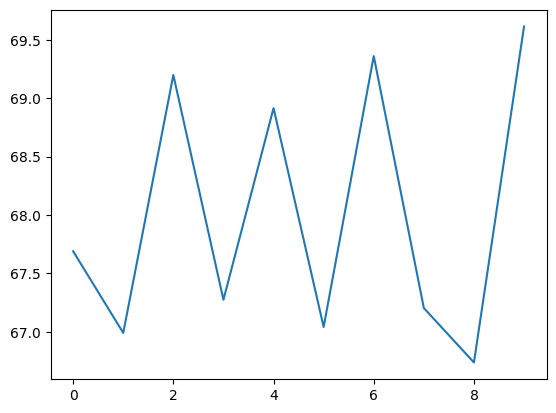

In [21]:

plt.plot(np.arange(len(train_performances)), train_performances)
# plt.savefig("Training_performances_CIFAR100.png")

# Guided Training
### Only update the class vectors which are wrong

In [22]:
@hd.run
def guided_retrain(class_hvs, hv_matrix, labels, N):
    search_results = hd.search(class_hvs, hv_matrix)

    for idx in range(N):
        if search_results[idx] != labels[idx]:
            class_hvs[labels[idx]] += hv_matrix[idx]
            class_hvs[search_results[idx]] -= hv_matrix[idx]

    return class_hvs


In [23]:
ITERS = 2000
n_classes = 10
class_hvs = hd.hypermatrix(n_classes)
train_performances = []
# Fetch Current Image batch
images, labels = next(iter(train_loader))
images = images.reshape(images.shape[0], images.shape[1]*images.shape[2]*images.shape[3]) * 255
labels = np.array(labels, dtype = np.int32)
# Encode the images of this batch
hv_matrix = hd.encode(
        encode_pixels, extra_args = (position_hvs, red_intensity_hvs, green_intensity_hvs, blue_intensity_hvs, 1024, 255),
        feature_matrix = images
        )
# bipolarize
hv_numpy = hv_matrix.to_numpy()
hv_numpy = bipolarize(hv_numpy)
hv_matrix = hv_matrix.from_numpy(hv_numpy)
for e in range(ITERS):
    # add to class_hvs
    class_hvs = guided_retrain(class_hvs, hv_matrix, labels, BATCH_SIZE)
    # bipolarize
    class_hvs_np = class_hvs.to_numpy()
    class_hvs_np = bipolarize(class_hvs_np)
    class_hvs = class_hvs.from_numpy(class_hvs_np)
    v = validate(labels, hd.search(class_hvs, hv_matrix).to_numpy())
    train_performances.append(v)
    print("At epoch ",e, ": ", v)

[ERROR]	jit.date_type_mutator	
<class '_ast.Module'> : 
  <class '_ast.For'> :  <RPT: N>
    <class '_ast.Assign'> :  [hv_matrix_idx_ead026f6 : __ARG__hv_matrix]
    <class '_ast.If'> : 
      then : 
        <class '_ast.Assign'> :  [__ARG__class_hvs : __ARG__class_hvs + hv_matrix_idx_ead026f6]
        <class '_ast.Assign'> :  [__ARG__class_hvs : __ARG__class_hvs + hv_matrix_idx_ead026f6]
      else : 

{'idx': <class 'int'>, 'N': <class 'int'>, 'search_results': 'np_int_array_type', 'labels': 'np_int_array_type', 'class_hvs': 'hypermat_type', 'hv_matrix': 'hypermat_type', '__ARG__labels': 'int*', '__ARG__labels__STRIDE__': 'const int', '__ARG__search_results': 'int*', '__ARG__search_results__STRIDE__': 'const int', '__ARG__hv_matrix': 'float*', '__ARG__class_hvs': 'float*', 'search_results_idx_b85d35f6': <class 'int'>, 'labels_idx_b9c77ce4': <class 'int'>, 'hv_matrix_idx_ead026f6': <class 'float'>, 'class_hvs_labels_idx_df62a0b1': <class 'float'>, 'class_hvs_idx_search_results_572d84

PyCUDA WARNING: a clean-up operation failed (dead context maybe?)
cuMemFree failed: an illegal memory access was encountered


LogicError: cuMemcpyDtoH failed: an illegal memory access was encountered

In [ ]:
print("On Test Data", validate(labels, hd.search(class_hvs, hv_matrix).to_numpy()))

In [ ]:
print("On Test Data", validate(labels_tst, hd.search(class_hvs, hv_matrix_tst).to_numpy()))